In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW
from monai.networks.nets import SegResNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from tqdm import tqdm
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.ndimage import label, generate_binary_structure, binary_erosion
from monai.transforms import Compose, EnsureChannelFirstd, EnsureTyped, MapTransform, transform
import itertools, time, random
from copy import deepcopy
from skimage.transform import resize
import math

#Funciones propias, están definidas en el .py que se encuentra en la misma carpeta que este script
from PreprocesamientoImagenes import procesar_imagenes, pad_to_divisible, cargar_masks, calcular_frecuencias_pixeles, show_masks, print_stats, _labels_to_index
from Funciones_defectos import calcular_diametros_defectos




In [2]:

# Añade una dimensión, necesario para algunos modelos

class AddAxisd(MapTransform):
    def __init__(self, keys, axis=0):
        super().__init__(keys)
        self.axis = axis
    def __call__(self, data):
        d = dict(data)
        for k in self.keys:
            x = d[k]
            if isinstance(x, torch.Tensor):
                if self.axis < 0:  # normaliza ejes negativos
                    self.axis = x.ndim + self.axis + 1
                d[k] = x.unsqueeze(self.axis)
            else:
                d[k] = np.expand_dims(np.asarray(x), axis=self.axis)
        return d

# Asegura que siempre binarizan las máscaras de la misma manera, eligiendo la clase minoritaria como defecto

class MinorityAsDefectd(MapTransform):

    def __init__(self, keys):
        super().__init__(keys)
    def __call__(self, data):
        d = dict(data)
        for k in self.keys:
            x = d[k]
            arr = x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else np.asarray(x)
            bin_mask = (arr > 0).astype(np.uint8)
            ones = int(bin_mask.sum())
            zeros = bin_mask.size - ones
            if ones == 0:
                fixed = bin_mask
            elif zeros == 0:
                fixed = np.zeros_like(bin_mask, np.uint8)
            else:
                fixed = (1 - bin_mask) if ones > zeros else bin_mask
            d[k] = torch.from_numpy(fixed) if isinstance(x, torch.Tensor) else fixed
        return d
    
def minority_as_defect(mask_np: np.ndarray) -> np.ndarray:
    """
    Devuelve máscara binaria con {0=bg, 1=defecto}, forzando que la clase minoritaria sea 1.
    Acepta HxW (o HxW con valores 0/255/float).
    """
    m = (mask_np > 0).astype(np.uint8)
    ones = int(m.sum())
    zeros = m.size - ones
    if ones == 0:
        return m
    if zeros == 0:
        return np.zeros_like(m, np.uint8)
    return (1 - m) if ones > zeros else m  

# Procesamiento para entrenamiento y validación

train_transforms = Compose([
    MinorityAsDefectd(keys=["label"]),                 
    EnsureChannelFirstd(keys=["image"], channel_dim=-1),  
    AddAxisd(keys=["label"], axis=0),                  
    EnsureTyped(keys=["image", "label"]),              
])

val_transforms = Compose([
    MinorityAsDefectd(keys=["label"]),
    EnsureChannelFirstd(keys=["image"], channel_dim=-1),
    AddAxisd(keys=["label"], axis=0),
    EnsureTyped(keys=["image", "label"]),
])


In [3]:
# Clases para la carga de datos para cada pérdida

#Clase para DiceLoss
class NudoDatasetRutas(torch.utils.data.Dataset):
    def __init__(self, rutas, image_size=(128, 128), margen=0, transforms=None):
        self.image_mask_pairs = []
        self.image_size = image_size
        self.margen = margen
        self.transforms = transforms

        for ruta in rutas:
            image_dir = os.path.join(ruta, "imgs")
            mask_dir  = os.path.join(ruta, "masks")
            image_paths = sorted(glob(os.path.join(image_dir, "*.tif")))
            mask_paths  = sorted(glob(os.path.join(mask_dir,  "*.tif")))
            self.image_mask_pairs.extend(zip(image_paths, mask_paths))

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        image_path, mask_path = self.image_mask_pairs[idx]

        
        imagen_vol = procesar_imagenes(image_path, self.image_size, self.margen) 
        mask_vol   = cargar_masks(mask_path,    self.image_size)                  
        data_dict = {"image": imagen_vol, "label": mask_vol}

        if self.transforms is not None:
            data_dict = self.transforms(data_dict)

        return {"image": data_dict["image"], "label": data_dict["label"]}



# Clase para cross entropy
class NudoDatasetRutasCE(Dataset):
    def __init__(self, rutas, image_size=(256, 256), margen=0, transforms=None):
        self.pairs = []
        self.image_size = image_size
        self.margen = margen
        self.transforms = transforms
        for ruta in rutas:
            image_dir = os.path.join(ruta, "imgs")
            mask_dir  = os.path.join(ruta, "masks")
            imgs  = sorted(glob(os.path.join(image_dir, "*.tif")))
            masks = sorted(glob(os.path.join(mask_dir,  "*.tif")))
            self.pairs.extend(zip(imgs, masks))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, msk_path = self.pairs[idx]
        # Estas funciones deben devolver numpy arrays HxWxC (imagen) y HxW (máscara)
        img_np  = procesar_imagenes(img_path, self.image_size, self.margen)  # HxWxC o HxW
        msk_np  = cargar_masks(msk_path, self.image_size)                     # HxW

        # Asegura canal en imagen
        if img_np.ndim == 2:
            img_np = img_np[..., None]  # HxW -> HxWx1

        
        msk_np = minority_as_defect(msk_np)  # HxW uint8
        img_t  = torch.from_numpy(img_np).permute(2, 0, 1).float()  # CHW
        lab_t  = torch.from_numpy(msk_np).long()                    # HW (índices)

        return {"image": img_t, "label": lab_t}


# Rutas de entrenamiento
rutas_train = [
    r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\Supervisado\Entrenamiento\Probetas_AIDIMME\DED_308_EST2",
    r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\Supervisado\Entrenamiento\Probetas_AIDIMME\DED_308_EST3 Y ENG_208_EST3",
    r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\Supervisado\Entrenamiento\Extra",
    r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\Supervisado\Entrenamiento\MADISON_ProbDefectos\Probeta_scalm_sin_anillo",
    r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\Supervisado\Entrenamiento\MADISON_ProbDefectos\Probeta_scalm_1_anillo",
    r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\Supervisado\Entrenamiento\MADISON_ProbDefectos\Probeta_scalm_2_anillos",
    r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\Supervisado\Entrenamiento\Nudos_Biobam_Reales"
]

# rutas de validación. Requiere añadir imágenes con máscaras
rutas_val = [
     r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\Supervisado\Pureba_Anillos\Probeta_no_anillo"
     r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\Supervisado\Pureba_Anillos\Probeta_anillo_1"
     r"C:\Users\unidad-epa\Desktop\Scripts CATEC\Reconstrucción\Supervisado\Pureba_Anillos\\Probeta_anillo_1"
]

# Datasets & Loaders



train_ds = NudoDatasetRutas(rutas_train, image_size=(256, 256), margen=0, transforms=train_transforms)
val_ds   = NudoDatasetRutas(rutas_val,   image_size=(256, 256), margen=0, transforms=val_transforms)

train_loader= DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=0)



print(f"Número total de imágenes en el conjunto de entrenamiento: {len(train_ds)}")
print(f"Número total de imágenes en el conjunto de validación: {len(val_ds)}")

# Comprobacion del tamaño de los conjuntos
batch = next(iter(train_loader))
print("image:", tuple(batch["image"].shape), batch["image"].dtype)  
print("label:", tuple(batch["label"].shape), batch["label"].dtype)  



Número total de imágenes en el conjunto de entrenamiento: 448
Número total de imágenes en el conjunto de validación: 0
image: (8, 3, 256, 256) torch.float32
label: (8, 1, 256, 256) torch.uint8


In [4]:
# Calculo de frecuencias para la ponderación de la pérdida

freq_defecto, freq_no_defecto = calcular_frecuencias_pixeles(train_ds)
print(f"Defectuoso: {freq_defecto}, No defectuoso: {freq_no_defecto}")

# Definición de dispositivo. Si hay gpu disponible usa la GPU, si no CPU

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")



class_weights_1 = torch.tensor([1/freq_no_defecto, 1/freq_defecto], dtype=torch.float32).to(DEVICE)

class_weights_2 = torch.tensor([1/(freq_no_defecto**0.5), 1/(freq_defecto**0.5)], dtype=torch.float32).to(DEVICE)

100%|██████████| 448/448 [01:30<00:00,  4.93it/s]


Defectuoso: 0.0019363675798688615, No defectuoso: 0.9980636324201312


In [5]:
# Pérdida híbrida

class HybridCELossDice(nn.Module):
    """
    Combina CrossEntropy (con pesos opcionales) + Dice.
    - outputs: logits [B, C, H, W(,D)]  (C=2 en binario con CE)
    - targets: índices 0/1 [B, H, W(,D)]  o [B,1,H,W(,D)]  o one-hot [B,C,H,W(,D)]
    """
    def __init__(self, ce_weight=0.5, dice_weight=0.5, class_weights=None, include_background=False):
        super().__init__()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
        self.ce = nn.CrossEntropyLoss(weight=class_weights)  # pesos [w_bg, w_fg] o None
        self.dice = DiceLoss(
            to_onehot_y=True,     # convertimos índices -> one-hot dentro del loss
            softmax=True,         # aplica softmax a outputs
            include_background=include_background  # suele ser False en binario desbalanceado
        )

    def _to_indices(self, y, num_classes):
        """ Devuelve índices [B, H, W(,D)] a partir de [B,H,W(,D)] / [B,1,...] / [B,C,...] """
        if y.dim() == 5 and y.size(1) == num_classes:   # one-hot 3D
            return y.argmax(dim=1).long()
        if y.dim() == 4 and y.size(1) == num_classes:   # one-hot 2D
            return y.argmax(dim=1).long()
        if (y.dim() in (4,5)) and y.size(1) == 1:       # canal singleton
            return y.squeeze(1).long()
        return y.long()                                  # ya viene como índices

    def forward(self, outputs, targets):
        # outputs: [B,C,...] logits; C=2
        C = outputs.size(1)
        # CE: necesita índices [B,H,W(,D)]
        targets_idx = self._to_indices(targets, num_classes=C)
        ce_loss = self.ce(outputs, targets_idx)

        # Dice (to_onehot_y=True): espera [B,1,H,W(,D)] de índices
        dice_targets = targets_idx.unsqueeze(1)  # añade canal
        dice_loss = self.dice(outputs, dice_targets)

        return self.ce_weight * ce_loss + self.dice_weight * dice_loss

RegSegNet

In [6]:
# Entrenamiento básico


model = SegResNet(
    spatial_dims=2,      
    in_channels=3,
    out_channels=2,
    init_filters=16,
    norm=Norm.BATCH,
    dropout_prob=0.0,
).to(DEVICE)

optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)

# Entrenamiento + Early Stopping 
best_val = float("inf")
best_state = None
patience = 10
counter = 0
train_losses, val_losses = [], []

EPOCHS=50 # Número de bucles de entrenamiento
ce_w=0.3

criterion = HybridCELossDice(
        ce_weight=ce_w,
        dice_weight=1 - ce_w,
        class_weights=class_weights_2,
        include_background=False
    )

for epoch in range(EPOCHS):
    model.train()
    run_loss = 0.0
    for bt in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Train"):
        x = bt["image"].to(DEVICE, non_blocking=True)   # [B,C,H,W]
        y = bt["label"].to(DEVICE, non_blocking=True)   # [B,H,W]
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)                               # [B,2,H,W]
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
    avg_tr = run_loss / max(1, len(train_loader))
    train_losses.append(avg_tr)

    model.eval()
    run_val = 0.0
    with torch.no_grad():
        for bt in val_loader:
            x = bt["image"].to(DEVICE, non_blocking=True)
            y = bt["label"].to(DEVICE, non_blocking=True)
            logits = model(x)
            loss = criterion(logits, y)
            run_val += loss.item()
    avg_val = run_val / max(1, len(val_loader))
    val_losses.append(avg_val)
    scheduler.step(avg_val)

    print(f"Epoch {epoch+1} | Train: {avg_tr:.4f} | Val: {avg_val:.4f}")

    if avg_val < best_val:
        best_val = avg_val
        counter = 0
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        print(f"Validación mejorada: (val={best_val:.4f})")
    else:
        counter += 1
        print(f"Sin mejora: {counter}/{patience}")
        if counter >= patience:
            print(f"Entrenamiento detenido en la época {epoch+1}")
            break

if best_state is not None:
    model.load_state_dict(best_state)
    torch.save(model.state_dict(), "SegResNet_hybrid_ce_dice_best.pth") # Guardado del modelo
    print(f"Mejor pérdida de validación: {best_val:.4f}")

c:\Users\unidad-epa\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/50 - Train: 100%|██████████| 56/56 [00:09<00:00,  6.13it/s]


Epoch 1 | Train: 0.8123 | Val: 0.0000
Validación mejorada: (val=0.0000)


Epoch 2/50 - Train: 100%|██████████| 56/56 [00:09<00:00,  6.09it/s]


Epoch 2 | Train: 0.7411 | Val: 0.0000
Sin mejora: 1/10


Epoch 3/50 - Train: 100%|██████████| 56/56 [00:09<00:00,  6.15it/s]


Epoch 3 | Train: 0.6929 | Val: 0.0000
Sin mejora: 2/10


Epoch 4/50 - Train: 100%|██████████| 56/56 [00:09<00:00,  6.10it/s]


Epoch 4 | Train: 0.6450 | Val: 0.0000
Sin mejora: 3/10


Epoch 5/50 - Train: 100%|██████████| 56/56 [00:09<00:00,  6.19it/s]


Epoch 5 | Train: 0.5268 | Val: 0.0000
Sin mejora: 4/10


Epoch 6/50 - Train: 100%|██████████| 56/56 [00:08<00:00,  6.23it/s]


Epoch 6 | Train: 0.4494 | Val: 0.0000
Sin mejora: 5/10


Epoch 7/50 - Train: 100%|██████████| 56/56 [00:08<00:00,  6.24it/s]


Epoch 7 | Train: 0.3438 | Val: 0.0000
Sin mejora: 6/10


Epoch 8/50 - Train: 100%|██████████| 56/56 [00:09<00:00,  6.19it/s]


Epoch 8 | Train: 0.3058 | Val: 0.0000
Sin mejora: 7/10


Epoch 9/50 - Train: 100%|██████████| 56/56 [00:09<00:00,  6.16it/s]


Epoch 9 | Train: 0.2674 | Val: 0.0000
Sin mejora: 8/10


Epoch 10/50 - Train: 100%|██████████| 56/56 [00:09<00:00,  6.19it/s]


Epoch 10 | Train: 0.2550 | Val: 0.0000
Sin mejora: 9/10


Epoch 11/50 - Train: 100%|██████████| 56/56 [00:09<00:00,  6.18it/s]

Epoch 11 | Train: 0.2583 | Val: 0.0000
Sin mejora: 10/10
Entrenamiento detenido en la época 11
Mejor pérdida de validación: 0.0000


In [ ]:
# Entrenamiento con búsqueda de hiperparámetros

param_grid = {
    "cw_name": ["class_weights_1", "class_weights_2"],
    "lr": [1e-3, 5e-4, 1e-4, 5e-5],
    "weight_decay": [1e-5, 1e-6],
    "ce_weight": [0.3, 0.5, 0.7],
    "init_filters": [16, 32],
}

# Crear todas las combinaciones
all_combos = list(itertools.product(
    param_grid["cw_name"],
    param_grid["lr"],
    param_grid["weight_decay"],
    param_grid["ce_weight"],
    param_grid["init_filters"]
))

# Si hay demasiadas, muestreamos 50 configs aleatorias. Se pueden poner más, pero va a tardar mucho en ejecutarse
random.seed(42)
search_combos = random.sample(all_combos, 50) # Cambiar 50 por el número de combomnaciones deseadas

print(f"🔎 Ejecutando Grid Search con {len(search_combos)} configuraciones...")

overall_best_val = float("inf")
overall_best_state = None
overall_best_params = None

for run_idx, (cw_name, lr, wd, ce_w, init_f) in enumerate(search_combos, start=1):
    print(f"\n========== Config {run_idx}/{len(search_combos)} ==========")
    print(f"class_weights={cw_name}, lr={lr}, weight_decay={wd}, ce_w={ce_w}, init_f={init_f}")

    # Definir class_weights correctos
    cw = class_weights_1 if cw_name == "class_weights_1" else class_weights_2

    # Pérdida híbrida 
    criterion = HybridCELossDice(
        ce_weight=ce_w,
        dice_weight=1 - ce_w,
        class_weights=cw,
        include_background=False
    )

    # Modelo
    model = SegResNet(
        spatial_dims=2,
        in_channels=3,
        out_channels=2,
        init_filters=init_f,
        norm=Norm.BATCH,
        dropout_prob=0.0,
    ).to(DEVICE)

    # Optimizador
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)

    # Entrenamiento + Early Stopping
    best_val = float("inf")
    best_state = None
    patience = 10 # Número de épocas sin mejora para que se detenga el entrenamiento
    counter = 0
    EPOCHS=50

    for epoch in range(EPOCHS):
        model.train()
        run_loss = 0.0
        for bt in tqdm(train_loader, desc=f"Config {run_idx} | Epoch {epoch+1}/{EPOCHS} - Train"):
            x = bt["image"].to(DEVICE, non_blocking=True)
            y = bt["label"].to(DEVICE, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            run_loss += loss.item()
        avg_tr = run_loss / max(1, len(train_loader))

        model.eval()
        run_val = 0.0
        with torch.no_grad():
            for bt in val_loader:
                x = bt["image"].to(DEVICE, non_blocking=True)
                y = bt["label"].to(DEVICE, non_blocking=True)
                logits = model(x)
                loss = criterion(logits, y)
                run_val += loss.item()
        avg_val = run_val / max(1, len(val_loader))
        scheduler.step(avg_val)

        print(f"Epoch {epoch+1} | Train: {avg_tr:.4f} | Val: {avg_val:.4f}")

        if avg_val < best_val:
            best_val = avg_val
            counter = 0
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            counter += 1
            if counter >= patience:
                print(f" Early stopping at epoch {epoch+1}")
                break

    # Guardar si es el mejor global
    if best_val < overall_best_val:
        overall_best_val = best_val
        overall_best_state = best_state
        overall_best_params = (cw_name, lr, wd, ce_w, init_f)
        print(f" Nuevo mejor global con val={best_val:.4f}")

# Guardar mejor modelO
if overall_best_state is not None:
    final_model = SegResNet(
        spatial_dims=2,
        in_channels=3,
        out_channels=2,
        init_filters=overall_best_params[4],
        norm=Norm.BATCH,
        dropout_prob=0.0,
    ).to(DEVICE)
    final_model.load_state_dict(overall_best_state)
    torch.save(final_model.state_dict(), "SegResNet_hybrid_HIPERPARAMETROS_ce_dice_best.pth")
    print(f"\nMejor configuración: {overall_best_params} | best val loss={overall_best_val:.4f}")


🔎 Ejecutando Grid Search con 50 configuraciones...

========== Config 1/50 ==========
class_weights=class_weights_2, lr=0.0001, weight_decay=1e-06, ce_w=0.5, init_f=32


Config 1 | Epoch 1/50 - Train: 100%|██████████| 56/56 [00:14<00:00,  3.74it/s]


Epoch 1 | Train: 0.7181 | Val: 0.0000


Config 1 | Epoch 2/50 - Train: 100%|██████████| 56/56 [00:14<00:00,  3.80it/s]


Epoch 2 | Train: 0.6491 | Val: 0.0000


Config 1 | Epoch 3/50 - Train: 100%|██████████| 56/56 [00:14<00:00,  3.79it/s]


Epoch 3 | Train: 0.6203 | Val: 0.0000


Config 1 | Epoch 4/50 - Train: 100%|██████████| 56/56 [00:14<00:00,  3.77it/s]


Epoch 4 | Train: 0.6017 | Val: 0.0000


Config 1 | Epoch 5/50 - Train: 100%|██████████| 56/56 [00:14<00:00,  3.77it/s]


Epoch 5 | Train: 0.5887 | Val: 0.0000


Config 1 | Epoch 6/50 - Train:  18%|█▊        | 10/56 [00:02<00:12,  3.74it/s]

In [ ]:
# Carga de los pesos si ya está entrenado

#Definición del modelo
model = SegResNet(
    spatial_dims=2,      
    in_channels=3,
    out_channels=2,       
    init_filters=16, #Si da fallo, cambiar 32 por 16 o  viceversa
    norm=Norm.BATCH,
    dropout_prob=0.0,
).to(DEVICE)


#Nombre modelo
ckpt = torch.load("SegResNet_MODELOBUENO.pth", map_location=DEVICE)
missing, unexpected = model.load_state_dict(ckpt, strict=False)
print("missing:", missing, " | unexpected:", unexpected)

# 3) Modo evaluación
model.eval()

missing: []  | unexpected: []


C:\Users\unidad-epa\AppData\Local\Temp\ipykernel_15344\1874862802.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("SegResNet_MODELOBUENO.pth", map_loc

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affi

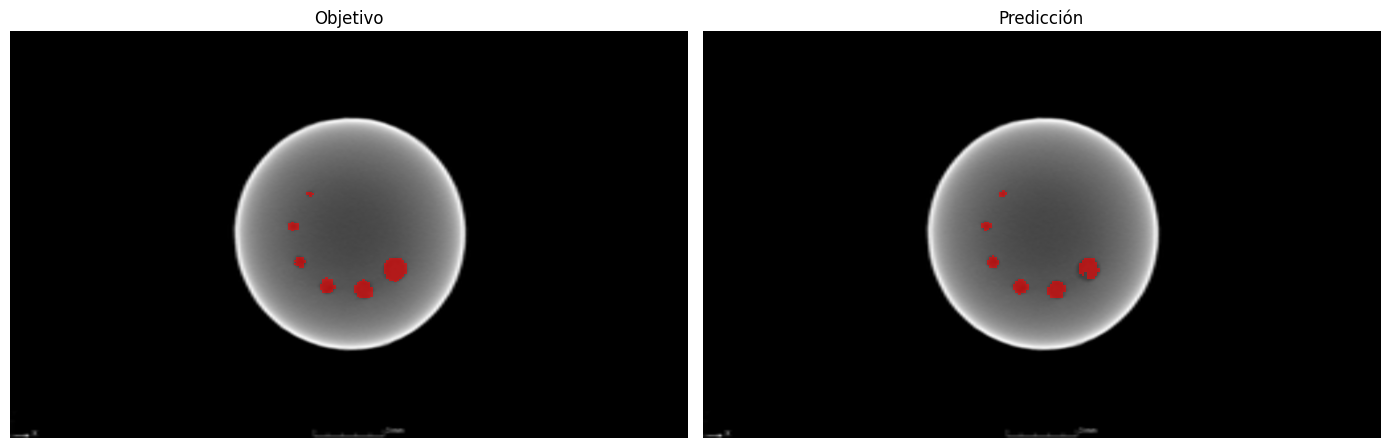

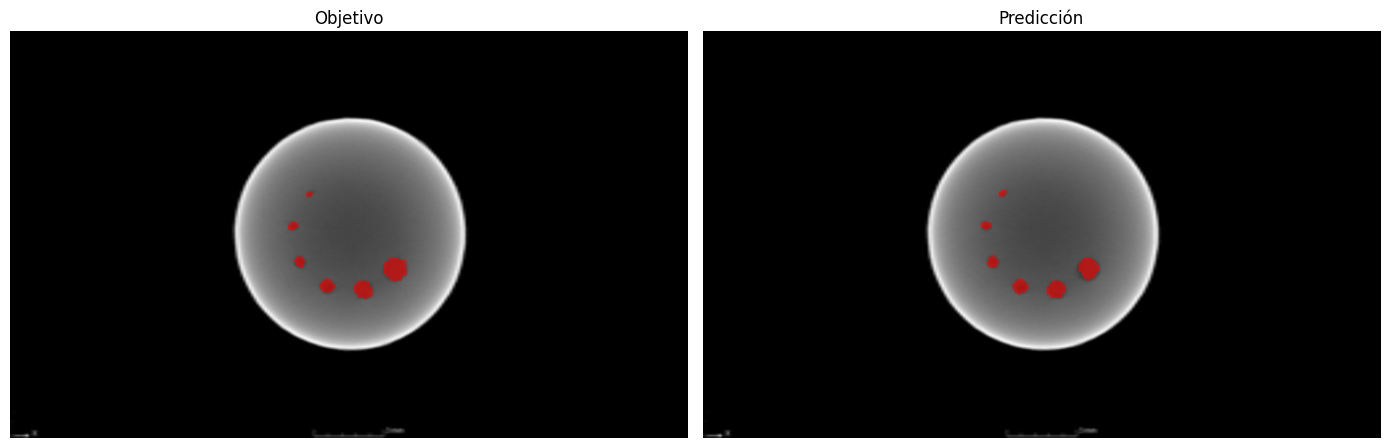

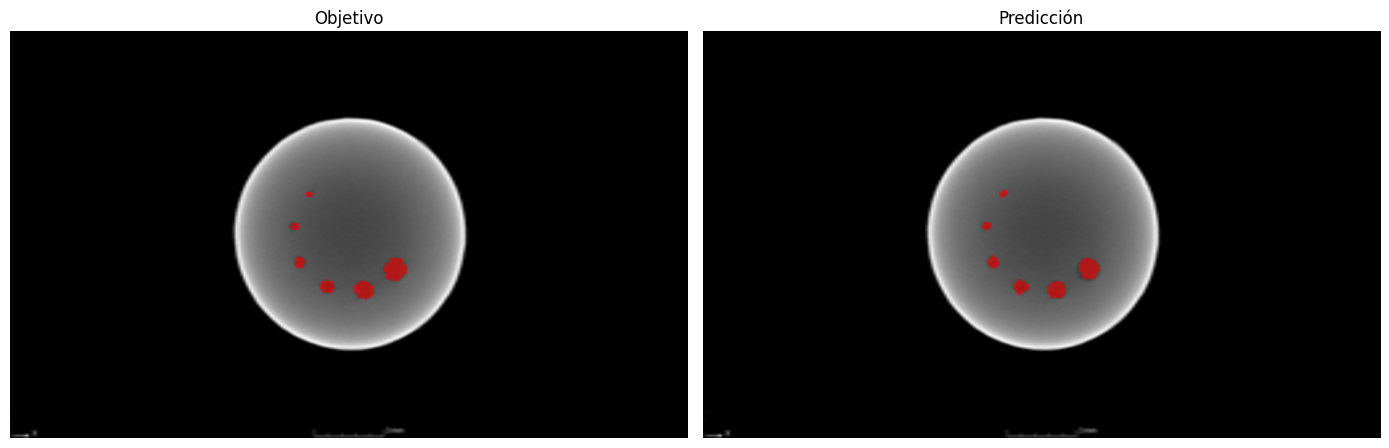

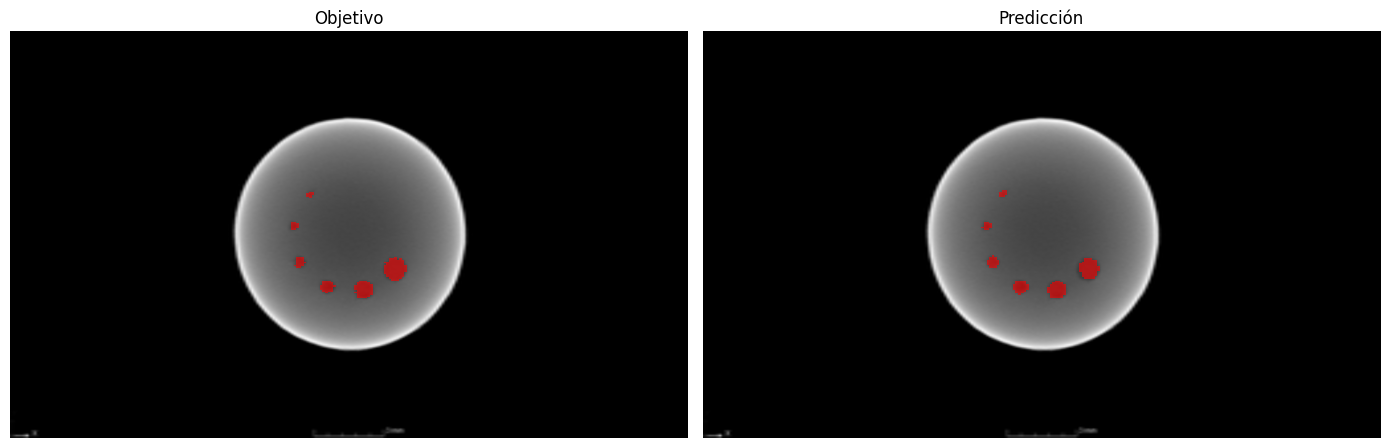

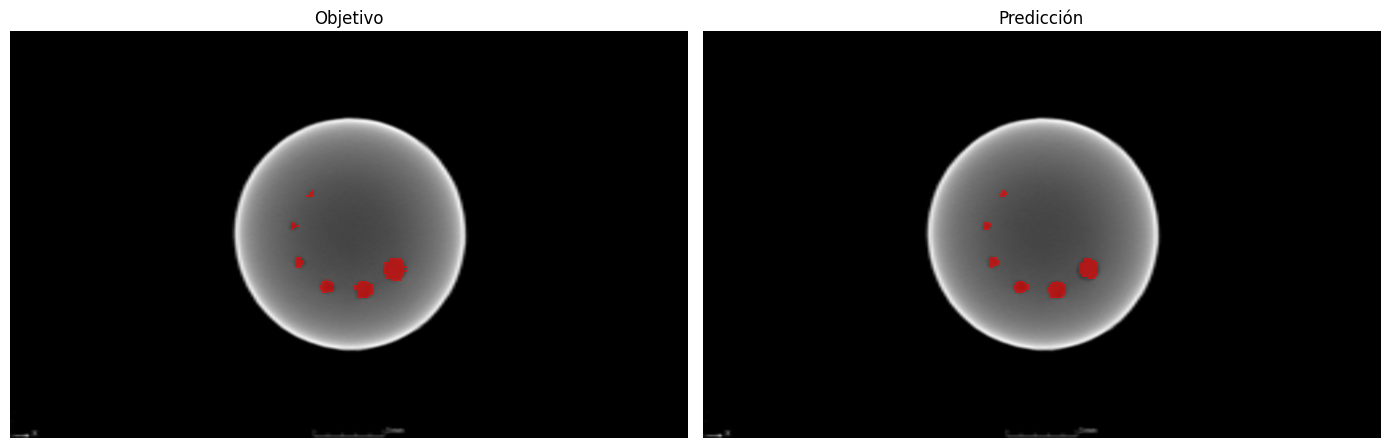

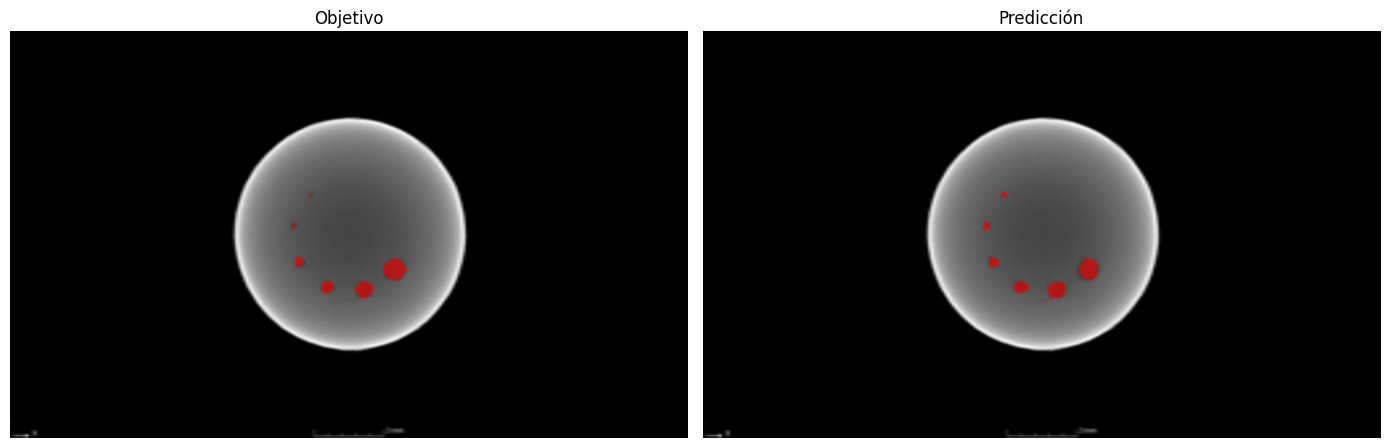

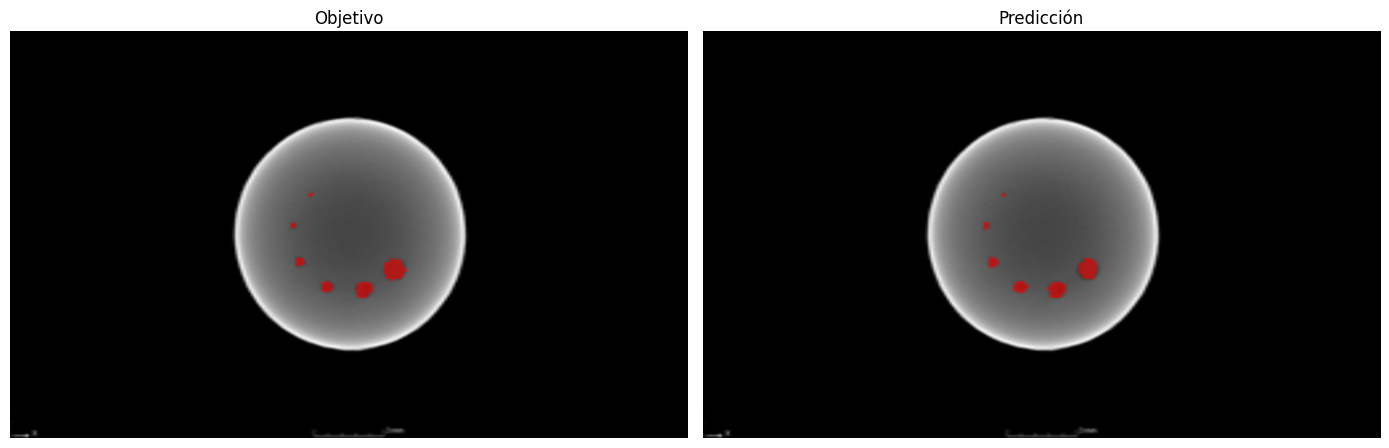

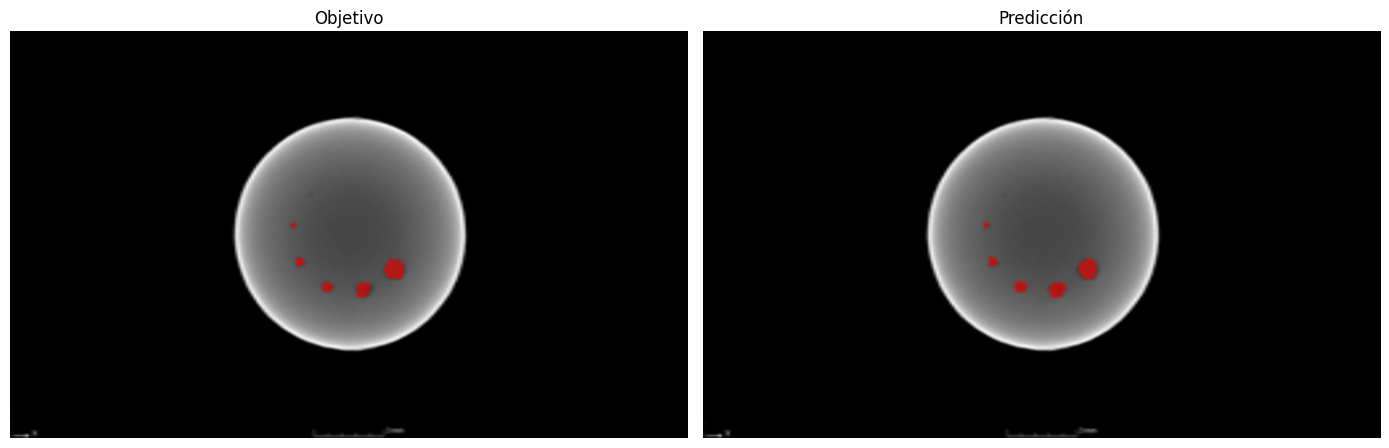

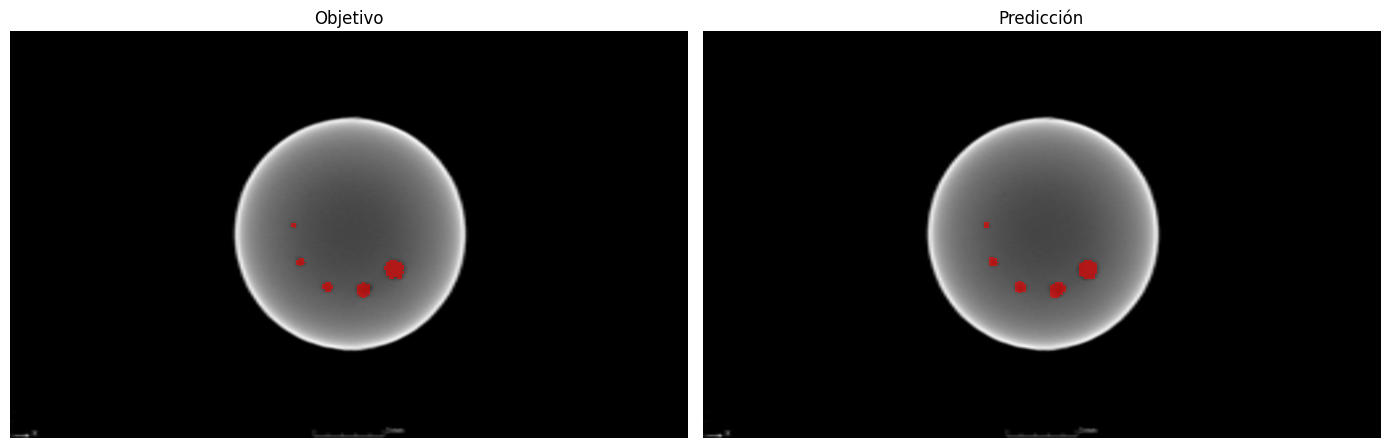

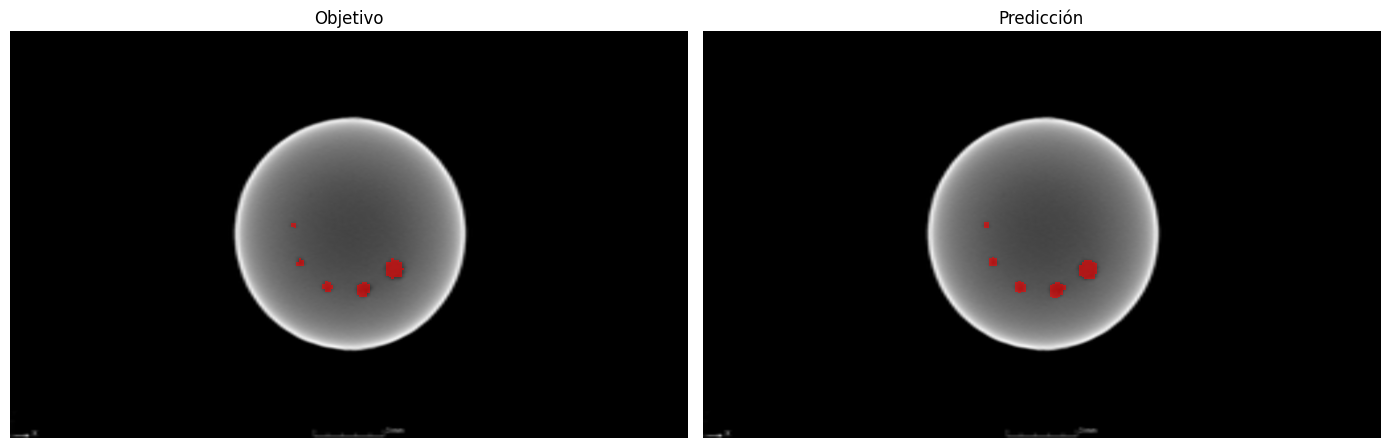

In [ ]:
def visualizar_preds_resize(
    model,
    val_loader_dice,
    DEVICE,
    orig_size=(593, 988),   # <-- dimensiones originales deseadas (alto, ancho)
    overlay_alpha=0.6,
    cmap_mask="autumn",
    canal_imagen=0
):
    """
    Visualiza imagen + máscara GT + pred redimensionadas a `orig_size`.
    Solo se muestra la clase=1 en la máscara (error).
    """
    model.eval()

    with torch.no_grad():
        for batch_idx, batch_data in enumerate(val_loader_dice):
            inputs = batch_data["image"].to(DEVICE)
            labels = batch_data["label"].to(DEVICE)

            
            if inputs.ndim == 5 and inputs.shape[-1] == 1:
                inputs = inputs.squeeze(-1)
            if labels.ndim == 5 and labels.shape[-1] == 1:
                labels = labels.squeeze(-1)

            outputs = model(inputs) 
            if outputs.ndim == 5:
                z = outputs.shape[-1] // 2 
                outputs = outputs[..., z]
                inputs  = inputs[...,  z]
                labels  = labels[...,  z]

            preds = torch.argmax(outputs, dim=1) 

        
            imgs_np  = inputs.detach().cpu().numpy()
            preds_np = preds.detach().cpu().numpy()
            labs_np  = labels.detach().cpu().numpy()

            B = imgs_np.shape[0]
            for i in range(B):
                if imgs_np.ndim == 4:  
                    img = imgs_np[i, canal_imagen, ...]
                else:                   
                    img = imgs_np[i, ...]

                img_resized = resize(img, orig_size, order=1, preserve_range=True, anti_aliasing=True)

            
                if labs_np.ndim == 4 and labs_np.shape[1] > 1:
                    mask_gt_full = labs_np[i, 1, ...]
                elif labs_np.ndim == 4 and labs_np.shape[1] == 1:
                    mask_gt_full = labs_np[i, 0, ...]
                else:
                    mask_gt_full = labs_np[i, ...]
                mask_gt_bin = (mask_gt_full == 1).astype(np.uint8)

                mask_pred_bin = (preds_np[i, ...] == 1).astype(np.uint8)

                mask_gt_bin_resized   = resize(mask_gt_bin, orig_size, order=0, preserve_range=True, anti_aliasing=False).astype(np.uint8)
                mask_pred_bin_resized = resize(mask_pred_bin, orig_size, order=0, preserve_range=True, anti_aliasing=False).astype(np.uint8)

                mask_gt_vis   = np.ma.masked_where(mask_gt_bin_resized != 1, mask_gt_bin_resized)
                mask_pred_vis = np.ma.masked_where(mask_pred_bin_resized != 1, mask_pred_bin_resized)

                # Visualización
                fig, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

                axs[0].imshow(img_resized, cmap="gray")
                axs[0].imshow(mask_gt_vis, cmap=cmap_mask, alpha=overlay_alpha, interpolation="nearest")
                axs[0].set_title("Objetivo"); axs[0].axis("off")

                axs[1].imshow(img_resized, cmap="gray")
                axs[1].imshow(mask_pred_vis, cmap=cmap_mask, alpha=overlay_alpha, interpolation="nearest")
                axs[1].set_title("Predicción"); axs[1].axis("off")

                plt.tight_layout()
                plt.show()


# Visualización de las predicciones. El precasamiento cambia el tamaño de las imágenes, si quieren verse sin modificaciones hay que señalar el tamaño original el la variable orig_size
visualizar_preds_resize(model, val_loader, DEVICE, orig_size=(1013, 1688))
